In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import scipy as sp

In [2]:
players = pd.read_pickle('players.pkl')
results = pd.read_pickle('results.pkl')
tournaments = pd.read_pickle('tournaments.pkl')

### Подсчет сложности турнира как средняя сложность вопроса

In [3]:
tournament_number_of_questions = {}
tournament_complexity_2019 = {}
tournament_complexity_2019_no_zeros = {}
tournament_complexity_2020 = {}
tournament_complexity_2020_no_zeros = {}
for tournament in tournaments.values():
    questionQty = tournament['questionQty']
    res = 0
    num_of_questions = 0
    if questionQty is not None:
        for complexity, num_of_questions_with_complexity in questionQty.items():
            res += int(complexity) * num_of_questions_with_complexity
            num_of_questions += num_of_questions_with_complexity
    if tournament['dateStart'] >= '2019-01-01' and tournament['dateStart'] < '2020-01-01':
        if num_of_questions != 0:
            tournament_complexity_2019[tournament['id']] = res/num_of_questions
        else:
            tournament_complexity_2019[tournament['id']] = 0
        if res != 0:
            tournament_complexity_2019_no_zeros[tournament['id']] = res/num_of_questions
        tournament_number_of_questions[tournament['id']] = num_of_questions
    elif tournament['dateStart'] >= '2020-01-01':
        if num_of_questions != 0:
            tournament_complexity_2020[tournament['id']] = res/num_of_questions
        else:
            tournament_complexity_2020[tournament['id']] = 0
        if res != 0:
            tournament_complexity_2020_no_zeros[tournament['id']] = res/num_of_questions
        tournament_number_of_questions[tournament['id']] = num_of_questions
            
print(len(tournament_complexity_2019))
print(len(tournament_complexity_2019_no_zeros))
print(len(tournament_complexity_2020))
print(len(tournament_complexity_2020_no_zeros))
print(len(tournament_number_of_questions))

tournament_complexity = tournament_complexity_2019
tournament_complexity.update(tournament_complexity_2020)

687
687
422
422
1109


### Подсчет сложности вопросов как процента правильных ответов и оценка рейтинга игроков 

In [4]:
tournament_ids_with_mask_number_of_questions_inconsistency = set()

player_real_rating_by_the_beginning_of_2019 = {}
player_real_rating_by_the_end_of_2019 = {}
player_estimated_rating_increase_in_2019 = {}

player_real_rating_by_the_beginning_of_2020 = {}
player_real_rating_by_the_end_of_2020 = {}
player_estimated_rating_increase_in_2020 = {}

team_player_ids_2019 = {}
team_player_ids_2020 = {}
percent_answered_by_team = {}

team_id = 1
for tournament_id, tournament_result in results.items():
    if tournament_id in tournament_number_of_questions:
        tournament_masks = []
        for team_result in tournament_result:
            if len(team_result['teamMembers']) > 0 and 'mask' in team_result and team_result['mask'] != None and len(team_result['mask']) >= tournament_number_of_questions[tournament_id]:
                team_mask = []
                for i in range(tournament_number_of_questions[tournament_id]):
                    question_result = team_result['mask'][i]
                    if question_result == '0' or question_result == '1':
                        team_mask.append(float(question_result))
                    else:
                        team_mask.append(0.5)
                tournament_masks.append(team_mask)
        if len(tournament_masks) == 0:
            tournament_ids_with_mask_number_of_questions_inconsistency.add(tournament_id)
        else:
            tournament_question_complexity = 1 - np.mean(np.array(tournament_masks), axis=0)
            for team_result in tournament_result:
                if len(team_result['teamMembers']) > 0 and 'mask' in team_result and team_result['mask'] != None and len(team_result['mask']) >= tournament_number_of_questions[tournament_id]:
                    team_mask = []
                    for i in range(tournament_number_of_questions[tournament_id]):
                        question_result = team_result['mask'][i]
                        if question_result == '0' or question_result == '1':
                            team_mask.append(float(question_result))
                        else:
                            team_mask.append(0.5)
                    percent_answered_by_team[team_id] = np.sum(np.array(team_mask)) / len(team_mask)
                    estimated_rating_increase = tournament_complexity[tournament_id] * np.dot(tournament_question_complexity, team_mask)
                    player_ids = []
                    for player in team_result['teamMembers']:
                        player_id = player['player']['id']
                        player_rating = player['rating']
                        player_ids.append(player_id)
                        if tournaments[tournament_id]['dateStart'] < '2020-01-01':
                            if player_id not in player_real_rating_by_the_beginning_of_2019:
                                player_real_rating_by_the_beginning_of_2019[player_id] = player_rating
                                player_real_rating_by_the_end_of_2019[player_id] = player_rating
                                player_estimated_rating_increase_in_2019[player_id] = estimated_rating_increase
                            else:
                                player_real_rating_by_the_end_of_2019[player_id] = player_rating
                                player_estimated_rating_increase_in_2019[player_id] += estimated_rating_increase
                        else:
                            if player_id not in player_real_rating_by_the_beginning_of_2020:
                                player_real_rating_by_the_beginning_of_2020[player_id] = player_rating
                                player_real_rating_by_the_end_of_2020[player_id] = player_rating
                                player_estimated_rating_increase_in_2020[player_id] = estimated_rating_increase
                            else:
                                player_real_rating_by_the_end_of_2020[player_id] = player_rating
                                player_estimated_rating_increase_in_2020[player_id] += estimated_rating_increase
                    if tournaments[tournament_id]['dateStart'] < '2020-01-01':
                        team_player_ids_2019[team_id] = player_ids
                    else:
                        team_player_ids_2020[team_id] = player_ids
                    team_id += 1
                        
print(len(tournament_ids_with_mask_number_of_questions_inconsistency))

262


### Baseline-модель, обучающая рейтинг-лист игроков

57429
57429
30409
30409
0.3891916126362257


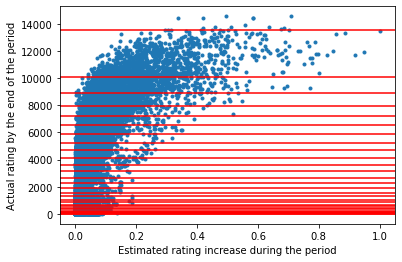

In [5]:
def get_category_upper_borders(array, num_of_categories):
    array_sorted = np.sort(array)
    category_size = int(len(array_sorted) / num_of_categories)
    category_upper_borders = []
    for i in range(num_of_categories):
        category_upper_border_index = (i + 1) * category_size - 1
        category_upper_borders.append(array_sorted[category_upper_border_index])
    return category_upper_borders

def get_category(element, category_upper_borders):
    num_of_categories = len(category_upper_borders)
    for i in range(num_of_categories):
        if element <= category_upper_borders[i]:
            return i
    return num_of_categories - 1

x_train = np.array(list(player_estimated_rating_increase_in_2019.values()))
print(len(x_train))
y_train = np.array(list(player_real_rating_by_the_end_of_2019.values()))
print(len(y_train))
x_train = x_train[y_train != 0]
print(len(x_train))
y_train = y_train[y_train != 0]
print(len(y_train))
x_train = np.interp(x_train, (x_train.min(), x_train.max()), (0, 1))
plt.scatter(x_train, y_train, marker='.')
plt.xlabel("Estimated rating increase during the period")
plt.ylabel("Actual rating by the end of the period")
category_upper_borders = get_category_upper_borders(y_train, 30)
y_train = np.array([get_category(y, category_upper_borders) for y in y_train])
for border in category_upper_borders:
    plt.axhline(y=border, color='red')
    
clf = LogisticRegression(random_state=0).fit(x_train.reshape(-1, 1), y_train)

x_test = np.array(list(player_estimated_rating_increase_in_2020.values()))
x_test = np.interp(x_test, (x_test.min(), x_test.max()), (0, 1))
y_test = np.array(list(player_real_rating_by_the_end_of_2020.values()))
y_test = np.array([get_category(y, category_upper_borders) for y in y_test])

score = clf.score(x_test.reshape(-1, 1), y_test)
print(score)

### Кластеризация по максимальному рейтингу игрока в команде

In [6]:
team_results = []
for team_id, player_ids in team_player_ids_2019.items():
    team_player_ratings = []
    for i in range(len(player_ids)):
        if player_ids[i] in player_estimated_rating_increase_in_2019:
            team_player_ratings.append(player_estimated_rating_increase_in_2019[player_ids[i]])
    team_results.append(-np.sort(-np.array(team_player_ratings)))
team_results = np.array(team_results)

<ipython-input-6-3e8cd289543f>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  team_results = np.array(team_results)


In [10]:
def e_step(xs, pis, mus, sigmas):
    k = mus.shape[0]
    z = np.array([ pis[i] * sp.stats.multivariate_normal.pdf(xs, mean=mus[i], cov=sigmas[i]) for i in range(k) ])
    print(mus[0])
    print(sp.stats.multivariate_normal.pdf(xs, mean=mus[0], cov=sigmas[0]))
    ## здесь z_{nk} = p(C_k)p(x_n|C_k)
    z = np.divide( z, np.sum(z, axis=0) ).T
    ## z_{nk} = p(C_k|x_n)
    return z

def m_step(xs, z):
    k = z.shape[1]
    pis = np.sum(z, axis=0) / np.sum(z)
    mus = np.array([np.average(xs, weights=z[:,i], axis=0) for i in range(k)])
    sigmas = np.array([np.cov(xs.T, aweights=z[:,i]) for i in range(k)])
    return pis, mus, sigmas

def loglikelihood(xs, pis, mus, sigmas):
    k = mus.shape[0]
    return np.sum(np.log(np.sum(np.array([ pis[i] * sp.stats.multivariate_normal.pdf(xs, mean=mus[i], cov=sigmas[i]) for i in range(k) ]), axis=0)))

In [13]:
x = []
for team_result in team_results:
    x.append([team_result[0], np.mean(team_result)])

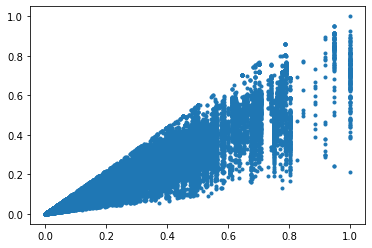

In [14]:
x = np.array(x)
x_max = x.max(axis=0)
x_min = x.min(axis=0)
x = (x - x_min) / (x_max - x_min)
plt.scatter(x[:, 0], x[:, 1], marker='.')

In [44]:
k = 7
mus = x[np.random.choice(x.shape[0], size=k, replace=False), 0 ]
sigmas = np.array( [ 1 for _ in range(k) ] )
pis = (1./k) * np.ones(k)
z = e_step( x[:, 0], pis, mus, sigmas)

## EM-алгоритм
old_logl, new_logl = -np.inf, -np.inf
for iIter in range(5000):
    old_logl = new_logl
    z = e_step( x[:, 0], pis, mus, sigmas)
    print(z)
    new_pis, new_mus, new_sigmas = m_step(x[:, 0], z)
    pis, mus, sigmas = new_pis, new_mus, new_sigmas
    new_logl = loglikelihood(x[:, 0], pis, mus, sigmas)
    print("Логарифм правдоподобия на итерации %03d: %.6f" % (iIter, new_logl) )
    if np.abs(new_logl - old_logl) < 0.01:
        break

print("После %d итераций правдоподобие = %.6f" % (iIter, new_logl) )

0.25354960175066954
[0.38094087 0.39892893 0.39873609 ... 0.38780876 0.3874972  0.38683082]
0.25354960175066954
[0.38094087 0.39892893 0.39873609 ... 0.38780876 0.3874972  0.38683082]
[[0.150053   0.13576742 0.1493237  ... 0.13505441 0.13462097 0.15413379]
 [0.14522355 0.14093206 0.14518724 ... 0.14059258 0.14038232 0.14451803]
 [0.14455926 0.1416343  0.14461427 ... 0.14134814 0.14116983 0.14323622]
 ...
 [0.14115355 0.14520582 0.14166217 ... 0.14520051 0.14519079 0.13681   ]
 [0.14109782 0.14526387 0.14161367 ... 0.14526326 0.14525637 0.13670681]
 [0.14098099 0.14538554 0.14151196 ... 0.14539479 0.14539384 0.13649069]]
Логарифм правдоподобия на итерации 000: 18482.534317
0.1959048608569016
[0.3662435  1.93369901 2.02978907 ... 1.33448528 1.31320799 1.268482  ]
[[0.15560273 0.12985035 0.15408341 ... 0.12870754 0.12801733 0.16510227]
 [0.14337974 0.14288532 0.14359934 ... 0.14269218 0.14256951 0.14093823]
 [0.14247304 0.14382828 0.14280936 ... 0.14371205 0.14363565 0.13926743]
 ...
 [0.

0.3073740748606426
[0.45263956 2.94380642 2.49739647 ... 0.22483999 0.21153986 0.18573817]
[[1.47699124e-01 3.78305676e-18 9.61602260e-02 ... 1.83574185e-32
  9.44790174e-60 7.56140558e-01]
 [2.92577530e-01 2.00536207e-03 3.22068045e-01 ... 3.09604690e-06
  1.23646348e-11 1.17781863e-01]
 [2.13893694e-01 1.84359018e-02 2.42398616e-01 ... 2.32029301e-04
  4.75316409e-08 7.84042098e-02]
 ...
 [7.33660232e-03 1.46292360e-01 8.22551297e-03 ... 2.85948344e-01
  5.30503161e-01 4.29358356e-03]
 [7.43839427e-03 1.46150278e-01 8.31982919e-03 ... 2.86776249e-01
  5.30173697e-01 4.44433128e-03]
 [7.85287539e-03 1.47993285e-01 8.73774638e-03 ... 2.90374455e-01
  5.24520629e-01 4.90702592e-03]]
Логарифм правдоподобия на итерации 018: 45174.502288
0.308193927794453
[0.44696383 2.95931238 2.49803649 ... 0.2132304  0.20036577 0.17545844]
[[1.44765390e-01 2.83898832e-18 9.46675050e-02 ... 1.43222653e-34
  1.36450256e-76 7.60567086e-01]
 [2.96435610e-01 2.31255574e-03 3.25682758e-01 ... 1.31031208e-06
 

Логарифм правдоподобия на итерации 030: 50309.432142
0.32345609342772563
[0.40753188 3.05107664 2.34992312 ... 0.08381092 0.07720757 0.06481842]
[[1.34606275e-001 2.34461804e-026 9.06045499e-002 ... 3.08775870e-084
  0.00000000e+000 7.74789175e-001]
 [3.30505570e-001 7.34433249e-004 3.59968900e-001 ... 2.47078559e-014
  4.21516173e-103 9.29054083e-002]
 [2.09147965e-001 1.60863430e-002 2.37341624e-001 ... 2.00422001e-009
  2.56147193e-072 5.50562696e-002]
 ...
 [1.22926230e-003 2.05488355e-002 1.56913347e-003 ... 6.10333885e-002
  9.08799861e-001 8.43943651e-004]
 [1.15293976e-003 1.76462924e-002 1.47265964e-003 ... 4.89452395e-002
  9.24721194e-001 8.18546139e-004]
 [1.30273667e-003 1.62733742e-002 1.66602976e-003 ... 3.77239915e-002
  9.36930094e-001 9.94120662e-004]]
Логарифм правдоподобия на итерации 031: 50420.253881
0.32420098106797635
[0.40890236 3.04653552 2.33697947 ... 0.08062916 0.07422338 0.06221858]
[[1.35344704e-001 1.89064505e-026 9.10815696e-002 ... 3.22554454e-089
  0.

[0.43295811 2.98299772 2.22221896 ... 0.06159901 0.0564488  0.0468669 ]
[[1.46214166e-001 6.16327002e-031 9.75518442e-002 ... 3.24822015e-131
  0.00000000e+000 7.56233990e-001]
 [3.27800185e-001 3.33910219e-004 3.57811030e-001 ... 1.71498464e-023
  8.44013647e-227 7.64136156e-002]
 [2.02199360e-001 1.25432727e-002 2.30722170e-001 ... 1.17872096e-015
  5.13637331e-160 4.42677793e-002]
 ...
 [9.42457663e-004 1.23782583e-002 1.23841986e-003 ... 1.36436286e-001
  8.41872838e-001 5.75097504e-004]
 [7.31116395e-004 8.44123691e-003 9.61788355e-004 ... 8.92041251e-002
  8.95397718e-001 4.62184302e-004]
 [7.14076341e-004 6.15250893e-003 9.41466763e-004 ... 5.60933180e-002
  9.31486666e-001 4.87067853e-004]]
Логарифм правдоподобия на итерации 042: 51612.880756
0.3307653448499706
[0.43629083 2.97549626 2.2122666  ... 0.060578   0.05550043 0.04605722]
[[1.47531753e-001 1.49970767e-031 9.83226149e-002 ... 3.37051906e-135
  0.00000000e+000 7.54145632e-001]
 [3.26695914e-001 2.88727923e-004 3.5670504

0.33626510568232554
[0.48220957 2.88099291 2.1026158  ... 0.05227524 0.047817   0.03954809]
[[1.63777774e-001 1.10815177e-035 1.09048584e-001 ... 9.63944913e-172
  0.00000000e+000 7.27173641e-001]
 [3.10627754e-001 8.37234541e-005 3.39480597e-001 ... 5.41680295e-032
  0.00000000e+000 6.19691515e-002]
 [1.87930598e-001 5.94818492e-003 2.15523142e-001 ... 1.31920881e-021
  0.00000000e+000 3.49947906e-002]
 ...
 [1.27625106e-003 2.00966401e-002 1.74040792e-003 ... 3.91860253e-001
  5.74486527e-001 6.28275830e-004]
 [7.26190787e-004 9.84683441e-003 9.92099715e-004 ... 1.91232225e-001
  7.91483348e-001 3.69922440e-004]
 [4.60278570e-004 4.44430273e-003 6.31153706e-004 ... 7.91387304e-002
  9.12059811e-001 2.52364563e-004]]
Логарифм правдоподобия на итерации 054: 52357.761092
0.3367851645143755
[0.48666079 2.87191278 2.09224215 ... 0.05152445 0.04712267 0.03896069]
[[1.65275134e-001 8.71601639e-036 1.10157552e-001 ... 1.27183120e-174
  0.00000000e+000 7.24567311e-001]
 [3.09168098e-001 7.895

Логарифм правдоподобия на итерации 068: 52663.176883
0.3437265859669094
[0.53961133 2.75481474 1.95104296 ... 0.04030299 0.03673829 0.03016395]
[[1.83297523e-001 9.19740712e-036 1.24794829e-001 ... 3.68041076e-217
  0.00000000e+000 6.91907645e-001]
 [2.92662980e-001 5.14010698e-005 3.18742896e-001 ... 1.65890811e-041
  0.00000000e+000 4.89852594e-002]
 [1.68033661e-001 3.94884892e-003 1.93225794e-001 ... 2.73437084e-028
  0.00000000e+000 2.62224437e-002]
 ...
 [1.36226943e-003 5.39218049e-002 1.99288209e-003 ... 7.33971544e-001
  1.96497411e-001 5.60188515e-004]
 [7.97880887e-004 2.79551551e-002 1.17122882e-003 ... 3.73660371e-001
  5.89589492e-001 3.39505677e-004]
 [3.01933790e-004 7.98724892e-003 4.46380860e-004 ... 9.25578933e-002
  8.96393858e-001 1.38278085e-004]]
Логарифм правдоподобия на итерации 069: 52677.451297
0.3441690503661407
[0.54262453 2.74742221 1.94178111 ... 0.03955013 0.03604197 0.0295748 ]
[[1.84364173e-001 9.56043754e-036 1.25722455e-001 ... 2.14704902e-220
  0.00

0.3480893995036054
[0.5680186  2.68089936 1.85793014 ... 0.03297431 0.02996647 0.02444605]
[[1.93820120e-001 7.52851601e-036 1.34091728e-001 ... 5.61205579e-253
  0.00000000e+000 6.72088148e-001]
 [2.84381868e-001 3.73836141e-005 3.08959744e-001 ... 6.04023689e-049
  0.00000000e+000 4.15974187e-002]
 [1.57072694e-001 3.00379868e-003 1.80869987e-001 ... 1.66945524e-033
  0.00000000e+000 2.13712063e-002]
 ...
 [1.12569675e-003 7.72436376e-002 1.72222094e-003 ... 8.40338344e-001
  6.80209381e-002 4.05521504e-004]
 [7.96582800e-004 4.92075378e-002 1.22414798e-003 ... 5.19541039e-001
  4.21466235e-001 2.97026604e-004]
 [2.31468506e-004 1.11902563e-002 3.59041100e-004 ... 9.78856117e-002
  8.88318877e-001 9.29566931e-005]]
Логарифм правдоподобия на итерации 080: 52798.668848
0.3484307479890172
[0.57013847 2.67498047 1.85046928 ... 0.03241763 0.0294528  0.02401359]
[[1.94665980e-001 6.85605159e-036 1.34843361e-001 ... 3.48418604e-256
  0.00000000e+000 6.70490655e-001]
 [2.83818954e-001 3.6048

[0.58791083 2.62320761 1.78567415 ... 0.02783758 0.0252315  0.02046844]
[[2.02423189e-001 1.35934356e-036 1.41588807e-001 ... 1.17351003e-286
  0.00000000e+000 6.55988001e-001]
 [2.79940997e-001 2.32137473e-005 3.03700179e-001 ... 5.87695218e-056
  0.00000000e+000 3.55921609e-002]
 [1.49285612e-001 2.09967627e-003 1.72159568e-001 ... 2.00385343e-038
  0.00000000e+000 1.75396941e-002]
 ...
 [9.02081690e-004 9.13945424e-002 1.42731463e-003 ... 8.74011813e-001
  2.14310995e-002 2.74785330e-004]
 [7.62352218e-004 7.02433208e-002 1.21254064e-003 ... 6.48719758e-001
  2.70365975e-001 2.40326416e-004]
 [1.88238345e-004 1.38645758e-002 3.02693517e-004 ... 1.03025782e-001
  8.80703008e-001 6.38897814e-005]]
Логарифм правдоподобия на итерации 091: 52873.145912
0.3515904221101554
[0.58938225 2.61878371 1.78020175 ... 0.02747408 0.0248969  0.02018819]
[[2.03142143e-001 1.08317366e-036 1.42190381e-001 ... 1.66507604e-289
  0.00000000e+000 6.54667473e-001]
 [2.79729199e-001 2.20432098e-005 3.0344815

0.3535478785078068
[0.60159267 2.58229501 1.73588971 ... 0.0247018  0.02234759 0.01805755]
[[2.09951830e-001 6.01953277e-038 1.47545091e-001 ... 9.75124129e-316
  0.00000000e+000 6.42503077e-001]
 [2.79383497e-001 1.21237829e-005 3.02995093e-001 ... 4.95852690e-062
  0.00000000e+000 3.07395909e-002]
 [1.44658010e-001 1.32833999e-003 1.67042355e-001 ... 1.07993186e-042
  0.00000000e+000 1.45376612e-002]
 ...
 [7.57381302e-004 9.86732279e-002 1.22063493e-003 ... 8.81423445e-001
  7.24763128e-003 1.86122751e-004]
 [7.17154524e-004 8.53807402e-002 1.16231590e-003 ... 7.36768797e-001
  1.66363974e-001 1.82216309e-004]
 [1.64690181e-004 1.58218532e-002 2.70086280e-004 ... 1.08205315e-001
  8.73569061e-001 4.49638921e-005]]
Логарифм правдоподобия на итерации 102: 52919.829542
0.3536974370409986
[0.60258915 2.57943188 1.73251246 ... 0.02450632 0.02216804 0.01790786]
[[2.10603032e-001 4.23965390e-038 1.48018021e-001 ... 3.84069341e-318
  0.00000000e+000 6.41378946e-001]
 [2.79527277e-001 1.1324

0.3547450824422363
[0.61063462 2.55879763 1.70940149 ... 0.02330463 0.02106564 0.01699108]
[[2.16917750e-01 6.73641716e-40 1.52168753e-01 ... 0.00000000e+00
  0.00000000e+00 6.30913496e-01]
 [2.82788505e-01 5.21618823e-06 3.06857854e-01 ... 3.55647803e-67
  0.00000000e+00 2.68547309e-02]
 [1.43190151e-01 7.47312171e-04 1.65446905e-01 ... 2.60453826e-46
  0.00000000e+00 1.22100768e-02]
 ...
 [6.86874617e-04 1.02132320e-01 1.10681711e-03 ... 8.81982463e-01
  2.99263983e-03 1.29382080e-04]
 [6.90745255e-04 9.39031678e-02 1.11929608e-03 ... 7.85998944e-01
  1.07678667e-01 1.34275479e-04]
 [1.55944870e-04 1.71054053e-02 2.55679976e-04 ... 1.12827502e-01
  8.67517051e-01 3.24466478e-05]]
Логарифм правдоподобия на итерации 113: 52952.766530
0.35480562438954427
[0.61125865 2.55753862 1.70815888 ... 0.0232573  0.02102238 0.01695537]
[[2.17532918e-01 4.16575349e-40 1.52527437e-01 ... 0.00000000e+00
  0.00000000e+00 6.29939644e-01]
 [2.83300589e-01 4.77864669e-06 3.07440253e-01 ... 1.31791762e-67

0.3547629358828345
[0.61690069 2.5561199  1.71270146 ... 0.02410972 0.02180985 0.01761966]
[[2.26467105e-01 5.91654292e-44 1.56661591e-01 ... 0.00000000e+00
  0.00000000e+00 6.16871304e-01]
 [2.95259486e-01 9.84863210e-07 3.21080640e-01 ... 1.18220826e-73
  0.00000000e+00 2.26560532e-02]
 [1.46938149e-01 2.45773113e-04 1.69643889e-01 ... 7.27122416e-51
  0.00000000e+00 9.78717664e-03]
 ...
 [6.90067762e-04 1.03538970e-01 1.07372888e-03 ... 8.81078990e-01
  1.20009366e-03 8.11567651e-05]
 [7.23197786e-04 9.86287215e-02 1.13065731e-03 ... 8.20320712e-01
  6.68390945e-02 8.73932570e-05]
 [1.65720957e-04 1.79673723e-02 2.61690607e-04 ... 1.18054220e-01
  8.61029555e-01 2.12380865e-05]]
Логарифм правдоподобия на итерации 129: 52995.322793
0.3546969920332727
[0.61702981 2.55716582 1.71452988 ... 0.02427372 0.02196097 0.01774648]
[[2.27042964e-01 2.90403012e-44 1.56849619e-01 ... 0.00000000e+00
  0.00000000e+00 6.16107416e-01]
 [2.96351280e-01 8.68886674e-07 3.22332245e-01 ... 4.83274970e-74


[0.61662298 2.57487239 1.74282313 ... 0.02672432 0.02422013 0.0196444 ]
[[2.32652884e-01 9.12450188e-48 1.58040753e-01 ... 0.00000000e+00
  0.00000000e+00 6.09306362e-01]
 [3.09334802e-01 2.11081508e-07 3.37351094e-01 ... 5.89239048e-78
  0.00000000e+00 2.06278320e-02]
 [1.54013542e-01 8.90784562e-05 1.77663095e-01 ... 6.92256602e-54
  0.00000000e+00 8.66592767e-03]
 ...
 [7.59643182e-04 1.03009546e-01 1.13077090e-03 ... 8.80770332e-01
  7.57834650e-04 6.18507503e-05]
 [8.09042655e-04 9.89112620e-02 1.20879318e-03 ... 8.33246028e-01
  5.21349224e-02 6.74152888e-05]
 [1.89218048e-04 1.80354859e-02 2.84911485e-04 ... 1.20929156e-01
  8.57726769e-01 1.65803339e-05]]
Логарифм правдоподобия на итерации 140: 53028.339557
0.35345911687904635
[0.61641515 2.5773193  1.74661224 ... 0.02705545 0.02452562 0.01990144]
[[2.33198593e-01 3.68915075e-48 1.58085155e-01 ... 0.00000000e+00
  0.00000000e+00 6.08716252e-01]
 [3.10836165e-01 1.80115734e-07 3.39107169e-01 ... 2.34889625e-78
  0.00000000e+00 2

[0.61012623 2.62514318 1.82099155 ... 0.03416037 0.03109421 0.02545337]
[[2.41089468e-01 5.32408559e-55 1.56767939e-01 ... 0.00000000e+00
  0.00000000e+00 6.02142593e-01]
 [3.37119299e-01 1.13083399e-08 3.70804347e-01 ... 1.04996268e-84
  0.00000000e+00 1.87408477e-02]
 [1.71844659e-01 1.31233884e-05 1.98717004e-01 ... 1.27850751e-58
  0.00000000e+00 7.70525251e-03]
 ...
 [9.71846588e-04 1.01161916e-01 1.33802777e-03 ... 8.80856629e-01
  4.28095633e-04 4.53317867e-05]
 [1.05350071e-03 9.72275504e-02 1.45295048e-03 ... 8.46696942e-01
  3.80274426e-02 4.99521253e-05]
 [2.55914174e-04 1.76947313e-02 3.54183872e-04 ... 1.24837002e-01
  8.53567156e-01 1.25787337e-05]]
Логарифм правдоподобия на итерации 156: 53086.431185
0.35011373005778945
[0.60953778 2.62885062 1.82689368 ... 0.03478605 0.03167389 0.02594554]
[[2.41601727e-01 1.63027239e-55 1.56529237e-01 ... 0.00000000e+00
  0.00000000e+00 6.01869036e-01]
 [3.39065039e-01 9.17404237e-09 3.73243340e-01 ... 3.70719901e-85
  0.00000000e+00 1

Логарифм правдоподобия на итерации 172: 53152.481990
0.34561229095386503
[0.59971775 2.68770747 1.92684012 ... 0.04736896 0.04336913 0.03594293]
[[2.50024035e-01 2.17733720e-64 1.49424218e-01 ... 0.00000000e+00
  0.00000000e+00 6.00551748e-01]
 [3.70457675e-01 2.37910222e-10 4.15799230e-01 ... 6.21579592e-93
  0.00000000e+00 1.78929372e-02]
 [2.00383675e-01 1.05736613e-06 2.35614713e-01 ... 2.20548856e-64
  0.00000000e+00 7.46163721e-03]
 ...
 [1.35731747e-03 9.96321608e-02 1.74584445e-03 ... 8.80508546e-01
  2.35695306e-04 3.71471227e-05]
 [1.49352699e-03 9.52135179e-02 1.91993098e-03 ... 8.57299531e-01
  2.71672571e-02 4.12484340e-05]
 [3.81111558e-04 1.73256540e-02 4.89220903e-04 ... 1.29258965e-01
  8.48876392e-01 1.07439954e-05]]
Логарифм правдоподобия на итерации 173: 53156.656039
0.34532402532750117
[0.59920867 2.69098138 1.93296381 ... 0.04829706 0.04423439 0.03668736]
[[2.50593872e-01 5.71365516e-65 1.48745065e-01 ... 0.00000000e+00
  0.00000000e+00 6.00661063e-01]
 [3.7229765

[0.59704677 2.72375901 2.00633908 ... 0.06210856 0.05715112 0.04787384]
[[2.60115140e-001 3.35323254e-073 1.35620355e-001 ... 0.00000000e+000
  0.00000000e+000 6.04264505e-001]
 [3.93545798e-001 5.77878053e-012 4.57158303e-001 ... 3.71118840e-101
  0.00000000e+000 1.79761151e-002]
 [2.29539661e-001 9.32579050e-008 2.80298300e-001 ... 3.85060951e-070
  0.00000000e+000 7.85644706e-003]
 ...
 [1.78834551e-003 1.00227759e-001 2.25737883e-003 ... 8.78714519e-001
  1.34209442e-004 3.53844877e-005]
 [1.98686345e-003 9.51161484e-002 2.50162472e-003 ... 8.63473245e-001
  1.96918706e-002 3.94647453e-005]
 [5.32430322e-004 1.74553843e-002 6.66614417e-004 ... 1.33586993e-001
  8.43934953e-001 1.06758855e-005]]
Логарифм правдоподобия на итерации 188: 53217.269855
0.34153698311202857
[0.59741564 2.72488407 2.01029489 ... 0.06309968 0.05808101 0.04868462]
[[2.60959715e-001 8.60752375e-074 1.34396643e-001 ... 0.00000000e+000
  0.00000000e+000 6.04643642e-001]
 [3.94645213e-001 4.48923308e-012 4.598356

0.3402094724139173
[0.60717698 2.72412488 2.03598953 ... 0.07227823 0.06671574 0.05625562]
[[2.71416218e-001 1.07281758e-079 1.19760180e-001 ... 0.00000000e+000
  0.00000000e+000 6.08823602e-001]
 [4.01746595e-001 3.51949095e-013 4.85851467e-001 ... 7.36831619e-108
  0.00000000e+000 1.84951258e-002]
 [2.48474210e-001 1.48728069e-008 3.18629170e-001 ... 7.77487630e-075
  0.00000000e+000 8.48816284e-003]
 ...
 [2.07934452e-003 1.02054666e-001 2.67741188e-003 ... 8.76366061e-001
  8.61409427e-005 3.68545097e-005]
 [2.32058276e-003 9.63056566e-002 2.97605542e-003 ... 8.66140566e-001
  1.52487793e-002 4.11836360e-005]
 [6.46041630e-004 1.79018583e-002 8.21225625e-004 ... 1.37077267e-001
  8.39709975e-001 1.15109561e-005]]
Логарифм правдоподобия на итерации 199: 53258.118752
0.3401592714766342
[0.60888128 2.72270537 2.03696988 ... 0.07308033 0.06747281 0.05692395]
[[2.72710275e-001 2.75657561e-080 1.18044995e-001 ... 0.00000000e+000
  0.00000000e+000 6.09244730e-001]
 [4.02042530e-001 2.7232

0.3418911868345119
[0.65646715 2.66563997 2.00797441 ... 0.08038764 0.07442918 0.06317211]
[[3.00074568e-001 3.71799509e-089 8.66661914e-002 ... 0.00000000e+000
  0.00000000e+000 6.13259240e-001]
 [3.96913523e-001 5.54839063e-015 5.26354808e-001 ... 5.61986972e-119
  0.00000000e+000 1.98961765e-002]
 [2.63781324e-001 9.56886481e-010 3.80982887e-001 ... 1.23744229e-082
  0.00000000e+000 9.88341279e-003]
 ...
 [2.28875805e-003 1.06482790e-001 3.23285682e-003 ... 8.71599227e-001
  4.24806278e-005 4.33298302e-005]
 [2.55972808e-003 9.95585439e-002 3.59143975e-003 ... 8.67712306e-001
  1.01109082e-002 4.84589455e-005]
 [7.55531591e-004 1.90466023e-002 1.04456883e-003 ... 1.42842899e-001
  8.32463086e-001 1.43192575e-005]]
Логарифм правдоподобия на итерации 215: 53314.260451
0.34220176193127677
[0.66137362 2.65919276 2.0027643  ... 0.08045769 0.07450276 0.06325048]
[[3.02542191e-001 9.43922233e-090 8.42195904e-002 ... 0.00000000e+000
  0.00000000e+000 6.13238218e-001]
 [3.95934287e-001 4.262

0.3504523947632234
[0.76571511 2.51799637 1.86718398 ... 0.07244156 0.06708308 0.05696067]
[[3.51282784e-001 6.39200197e-099 4.46349798e-002 ... 0.00000000e+000
  0.00000000e+000 6.04082236e-001]
 [3.72401424e-001 7.14823897e-017 5.71316596e-001 ... 2.53671892e-132
  0.00000000e+000 2.17776241e-002]
 [2.57617583e-001 5.22720530e-011 4.55282888e-001 ... 5.18666265e-092
  0.00000000e+000 1.17098481e-002]
 ...
 [2.03028059e-003 1.12529580e-001 3.51961634e-003 ... 8.65746131e-001
  1.89091328e-005 5.57783718e-005]
 [2.26035584e-003 1.04002638e-001 3.87723584e-003 ... 8.67484191e-001
  6.29458572e-003 6.22623356e-005]
 [7.09095820e-004 2.07153201e-002 1.18838438e-003 ... 1.49886890e-001
  8.23569678e-001 1.96621164e-005]]
Логарифм правдоподобия на итерации 231: 53381.311655
0.35125312258253966
[0.77465215 2.50558648 1.85410218 ... 0.0712154  0.06593739 0.05596972]
[[3.55295604e-001 1.47024211e-099 4.19875493e-002 ... 0.00000000e+000
  0.00000000e+000 6.02716847e-001]
 [3.70299196e-001 5.369

Логарифм правдоподобия на итерации 246: 53488.189334
0.36637821118292196
[0.91892397 2.27912652 1.59333542 ... 0.04239897 0.03898086 0.03259917]
[[4.20369161e-001 5.95472669e-110 9.78136374e-003 ... 0.00000000e+000
  0.00000000e+000 5.69849475e-001]
 [3.33088040e-001 4.99689091e-019 6.24887530e-001 ... 5.51796946e-149
  0.00000000e+000 2.28198406e-002]
 [2.27650383e-001 1.83947005e-012 5.54813686e-001 ... 9.70548899e-104
  0.00000000e+000 1.31813481e-002]
 ...
 [1.18383763e-003 1.20022829e-001 3.11047217e-003 ... 8.59636884e-001
  7.24976346e-006 7.09534478e-005]
 [1.29653989e-003 1.09159358e-001 3.35177466e-003 ... 8.66904001e-001
  3.57909361e-003 7.87194507e-005]
 [4.30407094e-004 2.28757565e-002 1.07352384e-003 ... 1.59090747e-001
  8.12468314e-001 2.68846313e-005]]
Логарифм правдоподобия на итерации 247: 53498.218426
0.3675143972503129
[0.92744838 2.26161478 1.57148815 ... 0.03996899 0.03671252 0.0306416 ]
[[4.24462061e-001 1.02393927e-110 8.42640154e-003 ... 0.00000000e+000
  0.0

Логарифм правдоподобия на итерации 257: 53624.726271
0.37830854923406293
[0.97488383 2.07009875 1.3210718  ... 0.01699615 0.01538609 0.01245194]
[[4.54361711e-001 5.26638450e-119 1.08437905e-003 ... 0.00000000e+000
  0.00000000e+000 5.44553910e-001]
 [3.00611214e-001 8.36906318e-021 6.67103761e-001 ... 2.17013070e-163
  0.00000000e+000 2.10566481e-002]
 [1.90637449e-001 1.13625067e-013 6.46015532e-001 ... 6.78364868e-114
  0.00000000e+000 1.23658700e-002]
 ...
 [4.78149275e-004 1.26217417e-001 2.09673368e-003 ... 8.55370242e-001
  3.29313418e-006 6.68660405e-005]
 [5.10555254e-004 1.13037214e-001 2.18981165e-003 ... 8.66762167e-001
  2.24438580e-003 7.34687235e-005]
 [1.73899984e-004 2.46931692e-002 7.10095259e-004 ... 1.67418356e-001
  8.02884630e-001 2.66142939e-005]]
Логарифм правдоподобия на итерации 258: 53639.538088
0.37925306004060394
[0.97437502 2.04909666 1.2931112  ... 0.01514376 0.01368119 0.01102425]
[[4.55768776e-001 6.67852894e-120 8.32207482e-004 ... 0.00000000e+000
  0.

[8.85754709e-01 1.72836486e+00 9.05529555e-01 ... 2.12783309e-03
 1.85568499e-03 1.38738757e-03]
[[4.45712964e-001 8.44820923e-134 1.44321319e-005 ... 0.00000000e+000
  0.00000000e+000 5.54272604e-001]
 [2.47592821e-001 1.03113937e-023 7.33047794e-001 ... 3.23902310e-189
  0.00000000e+000 1.43656501e-002]
 [1.25766490e-001 1.12831707e-015 7.74824451e-001 ... 3.93676794e-132
  0.00000000e+000 7.74060716e-003]
 ...
 [5.88100032e-005 1.36161611e-001 6.96985882e-004 ... 8.47289894e-001
  8.44786996e-007 2.90721496e-005]
 [5.92378180e-005 1.18401699e-001 6.79909461e-004 ... 8.65102317e-001
  1.00105113e-003 3.10525443e-005]
 [2.05575229e-005 2.77785812e-002 2.19640120e-004 ... 1.82760561e-001
  7.84922518e-001 1.22173915e-005]]
Логарифм правдоподобия на итерации 273: 53833.014144
0.3892850910115204
[8.78233464e-01 1.70600684e+00 8.82443963e-01 ... 1.85597455e-03
 1.61465521e-03 1.20095070e-03]
[[4.44143799e-001 6.94097622e-135 1.13164544e-005 ... 0.00000000e+000
  0.00000000e+000 5.55844885

[8.31584331e-01 1.51753202e+00 7.08853929e-01 ... 6.24996482e-04
 5.33494836e-04 3.81112340e-04]
[[4.35628917e-001 3.89127085e-146 2.29680744e-006 ... 0.00000000e+000
  0.00000000e+000 5.64368786e-001]
 [2.13560364e-001 3.73072867e-026 7.72652182e-001 ... 1.05438539e-214
  0.00000000e+000 1.02722700e-002]
 [9.48365584e-002 2.33343489e-017 8.27301672e-001 ... 3.90701645e-150
  0.00000000e+000 5.11208645e-003]
 ...
 [1.66409993e-005 1.44553801e-001 3.67562555e-004 ... 8.38174726e-001
  2.25879713e-007 1.31520720e-005]
 [1.60237393e-005 1.22054991e-001 3.42036157e-004 ... 8.61734270e-001
  4.56963195e-004 1.36221766e-005]
 [5.81015210e-006 3.07090214e-002 1.14855361e-004 ... 1.98439534e-001
  7.65840602e-001 5.77255557e-006]]
Логарифм правдоподобия на итерации 284: 53902.847093
0.3935670011971834
[8.29751736e-01 1.50248862e+00 6.96548947e-01 ... 5.76787274e-04
 4.91674984e-04 3.50226144e-04]
[[4.35588237e-001 2.81032458e-147 2.11663684e-006 ... 0.00000000e+000
  0.00000000e+000 5.64409647

Логарифм правдоподобия на итерации 299: 53967.634028
0.3977861403978643
[8.35702819e-01 1.33457467e+00 5.72894261e-01 ... 2.56269122e-04
 2.15603277e-04 1.49358813e-04]
[[4.44883009e-001 5.04556384e-164 1.58154838e-006 ... 0.00000000e+000
  0.00000000e+000 5.55115409e-001]
 [1.83752728e-001 9.60978250e-030 8.05897865e-001 ... 5.39185243e-263
  0.00000000e+000 7.14798192e-003]
 [7.46243928e-002 7.74238094e-020 8.55350039e-001 ... 2.94218982e-184
  0.00000000e+000 3.32919541e-003]
 ...
 [6.48200411e-006 1.59618080e-001 2.84347887e-004 ... 8.19450283e-001
  1.72117148e-008 5.68454724e-006]
 [5.85185530e-006 1.27553045e-001 2.49762798e-004 ... 8.54038279e-001
  9.89704759e-005 5.56004931e-006]
 [2.40575545e-006 3.67384511e-002 9.64493549e-005 ... 2.31464607e-001
  7.24870077e-001 2.71273012e-006]]
Логарифм правдоподобия на итерации 300: 53971.546365
0.3980279510841885
[8.37267920e-01 1.32597066e+00 5.67137684e-01 ... 2.46728365e-04
 2.07455526e-04 1.43537055e-04]
[[4.45815426e-001 4.243461

0.4010609762937786
[8.62103281e-01 1.22267375e+00 5.00991208e-01 ... 1.57794633e-04
 1.31790916e-04 8.98988076e-05]
[[4.58776524e-001 3.00189474e-179 2.30617414e-006 ... 0.00000000e+000
  0.00000000e+000 5.41221170e-001]
 [1.65670452e-001 7.60962782e-033 8.25509342e-001 ... 7.57387947e-316
  0.00000000e+000 5.58681529e-003]
 [6.42772086e-002 5.45479451e-022 8.67943386e-001 ... 1.21643714e-221
  0.00000000e+000 2.50119478e-003]
 ...
 [3.88548482e-006 1.77535931e-001 3.09238908e-004 ... 7.97036058e-001
  7.97325722e-010 3.27936390e-006]
 [3.27783704e-006 1.33354011e-001 2.56491061e-004 ... 8.45501645e-001
  1.60043235e-005 3.00490267e-006]
 [1.55417109e-006 4.44641348e-002 1.16808304e-004 ... 2.75469504e-001
  6.70518826e-001 1.70004359e-006]]
Логарифм правдоподобия на итерации 315: 54022.575674
0.40125571415101824
[8.63905637e-01 1.21622700e+00 4.97012202e-01 ... 1.53443005e-04
 1.28103509e-04 8.73071213e-05]
[[4.59634443e-001 3.50700862e-180 2.37979509e-006 ... 0.00000000e+000
  0.0000

0.4037319147813783
[8.87686156e-01 1.13503280e+00 4.48058532e-01 ... 1.07009649e-04
 8.88662518e-05 5.98899750e-05]
[[4.70099607e-001 6.48890926e-192 3.79389795e-006 ... 0.00000000e+000
  0.00000000e+000 5.29896599e-001]
 [1.51593347e-001 1.89624764e-035 8.40596105e-001 ... 0.00000000e+000
  0.00000000e+000 4.64728523e-003]
 [5.66447428e-002 8.38485644e-024 8.78396908e-001 ... 7.61265214e-257
  0.00000000e+000 2.01819304e-003]
 ...
 [2.62272055e-006 1.97232580e-001 3.81591319e-004 ... 7.72839641e-001
  3.02359298e-011 2.21482684e-006]
 [2.06903270e-006 1.39355901e-001 2.99482843e-004 ... 8.37097691e-001
  2.30695788e-006 1.90193483e-006]
 [1.11466799e-006 5.30717708e-002 1.58915965e-004 ... 3.27559105e-001
  6.06956233e-001 1.22828438e-006]]
Логарифм правдоподобия на итерации 330: 54056.179374
0.4038926728095726
[8.89259689e-01 1.12978947e+00 4.44965284e-01 ... 1.04475281e-04
 8.67310931e-05 5.84075216e-05]
[[4.70732112e-001 1.17874869e-192 3.92633828e-006 ... 0.00000000e+000
  0.00000

0.4058199921246056
[9.08105340e-01 1.06694359e+00 4.08476934e-01 ... 7.77032761e-05
 6.42263879e-05 4.28558877e-05]
[[4.77609245e-001 3.88215122e-201 6.13730558e-006 ... 0.00000000e+000
  0.00000000e+000 5.22384618e-001]
 [1.40677382e-001 2.37873147e-037 8.52218926e-001 ... 0.00000000e+000
  0.00000000e+000 4.10420895e-003]
 [5.08989367e-002 3.95180617e-025 8.87478852e-001 ... 7.87166639e-283
  0.00000000e+000 1.74350933e-003]
 ...
 [1.91482669e-006 2.14133785e-001 4.89465533e-004 ... 7.52232912e-001
  1.99558674e-012 1.71808877e-006]
 [1.43398466e-006 1.44351477e-001 3.68855756e-004 ... 8.30309745e-001
  4.62474904e-007 1.40377491e-006]
 [8.42611605e-007 6.02860761e-002 2.18747966e-004 ... 3.74111219e-001
  5.50758050e-001 9.93628424e-007]]
Логарифм правдоподобия на итерации 344: 54074.032143
0.4059569547334318
[9.09434418e-01 1.06247172e+00 4.05920698e-01 ... 7.60313111e-05
 6.28243150e-05 4.18919505e-05]
[[4.78040068e-001 1.04900331e-201 6.35006213e-006 ... 0.00000000e+000
  0.00000

[[4.82241235e-001 1.08553252e-207 9.48053633e-006 ... 0.00000000e+000
  0.00000000e+000 5.17749284e-001]
 [1.31886359e-001 1.06236663e-038 8.61527191e-001 ... 0.00000000e+000
  0.00000000e+000 3.78305620e-003]
 [4.63857884e-002 4.51300936e-026 8.95330012e-001 ... 1.67957607e-300
  0.00000000e+000 1.58205209e-003]
 ...
 [1.46375086e-006 2.26943858e-001 6.24369325e-004 ... 7.36630791e-001
  2.69323158e-013 1.46082849e-006]
 [1.05662850e-006 1.48077709e-001 4.58336377e-004 ... 8.25300327e-001
  1.41594531e-007 1.15333119e-006]
 [6.54334537e-007 6.55025625e-002 2.92964545e-004 ... 4.09664140e-001
  5.08170780e-001 8.64832455e-007]]
Логарифм правдоподобия на итерации 357: 54083.501402
0.4076154579520982
[9.25273933e-01 1.00814908e+00 3.75281156e-01 ... 5.78832892e-05
 4.76368309e-05 3.14954657e-05]
[[4.82516683e-001 3.99168872e-208 9.79407462e-006 ... 0.00000000e+000
  0.00000000e+000 5.17473523e-001]
 [1.31253148e-001 8.64698288e-039 8.62195543e-001 ... 0.00000000e+000
  0.00000000e+000 3.

[9.38719948e-01 9.59667434e-01 3.48574946e-01 ... 4.47111108e-05
 3.66558753e-05 2.40396919e-05]
[[4.85208926e-001 5.18275912e-213 1.47165985e-005 ... 0.00000000e+000
  0.00000000e+000 5.14776357e-001]
 [1.23487679e-001 8.56212175e-040 8.70365161e-001 ... 0.00000000e+000
  0.00000000e+000 3.56504342e-003]
 [4.21844846e-002 7.78353688e-027 9.03049412e-001 ... 6.46349515e-314
  0.00000000e+000 1.47216549e-003]
 ...
 [1.11082484e-006 2.37411017e-001 8.04180512e-004 ... 7.23862842e-001
  5.47342504e-014 1.30032133e-006]
 [7.78992710e-007 1.51090976e-001 5.79770144e-004 ... 8.21255721e-001
  5.52239114e-008 1.00027571e-006]
 [4.99040308e-007 6.95159878e-002 3.92372017e-004 ... 4.38328234e-001
  4.74033245e-001 7.80803072e-007]]
Логарифм правдоподобия на итерации 371: 54089.660888
0.4091900088993047
[9.39666300e-01 9.56139664e-01 3.46655299e-01 ... 4.38525539e-05
 3.59416402e-05 2.35568972e-05]
[[4.85354310e-001 2.46253087e-213 1.51645364e-005 ... 0.00000000e+000
  0.00000000e+000 5.14630526

0.41049704410475474
[9.50954675e-01 9.12543863e-01 3.23202111e-01 ... 3.42600629e-05
 2.79765134e-05 1.81940357e-05]
[[4.86585300e-001 5.62812314e-217 2.19601399e-005 ... 0.00000000e+000
  0.00000000e+000 5.13392740e-001]
 [1.15959271e-001 1.31877809e-040 8.78232545e-001 ... 0.00000000e+000
  0.00000000e+000 3.43380378e-003]
 [3.85242031e-002 2.11062396e-027 9.09929291e-001 ... 3.95252517e-323
  0.00000000e+000 1.40517062e-003]
 ...
 [8.50295777e-007 2.44961452e-001 1.01292465e-003 ... 7.14620580e-001
  1.78820245e-014 1.20909954e-006]
 [5.83991293e-007 1.53243430e-001 7.22520510e-004 ... 8.18351339e-001
  2.85120931e-008 9.13843173e-007]
 [3.81098707e-007 7.22200548e-002 5.09045471e-004 ... 4.58499635e-001
  4.50119378e-001 7.31601111e-007]]
Логарифм правдоподобия на итерации 385: 54093.637094
0.41059221518087674
[9.51749934e-01 9.09353385e-01 3.21505596e-01 ... 3.36283503e-05
 2.74530266e-05 1.78430794e-05]
[[4.86634837e-001 3.22617799e-217 2.25594063e-005 ... 0.00000000e+000
  0.000

Логарифм правдоподобия на итерации 395: 54095.700153
0.4115056004888593
[9.59184259e-01 8.78622744e-01 3.05307022e-01 ... 2.79970972e-05
 2.27932476e-05 1.47285922e-05]
[[4.86838255e-001 2.19895367e-219 2.91575870e-005 ... 0.00000000e+000
  0.00000000e+000 5.13132587e-001]
 [1.10563514e-001 4.24623005e-041 8.83835874e-001 ... 0.00000000e+000
  0.00000000e+000 3.37161737e-003]
 [3.59690611e-002 9.57677662e-028 9.14726422e-001 ... 0.00000000e+000
  0.00000000e+000 1.37266912e-003]
 ...
 [6.92820607e-007 2.49320320e-001 1.19036952e-003 ... 7.09258287e-001
  9.52169480e-015 1.16754050e-006]
 [4.69977931e-007 1.54473385e-001 8.44877115e-004 ... 8.16673656e-001
  1.96458854e-008 8.73870709e-007]
 [3.09050918e-007 7.36846539e-002 6.09378586e-004 ... 4.69845262e-001
  4.36711521e-001 7.08923585e-007]]
Логарифм правдоподобия на итерации 396: 54095.880236
0.4115932599925299
[9.59878381e-01 8.75663101e-01 3.03760737e-01 ... 2.74964761e-05
 2.23796211e-05 1.44530253e-05]
[[4.86832213e-001 1.407317

Логарифм правдоподобия на итерации 409: 54097.877042
0.41267610365876967
[9.68161914e-01 8.38962579e-01 2.84792976e-01 ... 2.18529302e-05
 1.77250000e-05 1.13635916e-05]
[[4.86400048e-001 8.79529046e-222 4.01705817e-005 ... 0.00000000e+000
  0.00000000e+000 5.13559781e-001]
 [1.04293083e-001 1.37766157e-041 8.90308280e-001 ... 0.00000000e+000
  0.00000000e+000 3.32797197e-003]
 [3.30768511e-002 4.37041235e-028 9.20067606e-001 ... 0.00000000e+000
  0.00000000e+000 1.34881830e-003]
 ...
 [5.37756383e-007 2.53402365e-001 1.42280804e-003 ... 7.04201716e-001
  5.35073564e-015 1.13959491e-006]
 [3.60347387e-007 1.55611289e-001 1.00619326e-003 ... 8.15095237e-001
  1.39739243e-008 8.45463063e-007]
 [2.37971144e-007 7.49724724e-002 7.42354686e-004 ... 4.80197228e-001
  4.24506160e-001 6.93833221e-007]]
Логарифм правдоподобия на итерации 410: 54098.007375
0.4127552002568953
[9.68745529e-01 8.36272157e-01 2.83417797e-01 ... 2.14783958e-05
 1.74166804e-05 1.11597702e-05]
[[4.86343138e-001 6.25840

0.41358790182713917
[9.74708928e-01 8.07878494e-01 2.69035582e-01 ... 1.78271807e-05
 1.44153901e-05 9.18187409e-06]
[[4.85542904e-001 2.20288770e-223 5.10569957e-005 ... 0.00000000e+000
  0.00000000e+000 5.14406039e-001]
 [9.94163700e-002 6.50793069e-042 8.95311955e-001 ... 0.00000000e+000
  0.00000000e+000 3.31273341e-003]
 [3.08877597e-002 2.59228372e-028 9.23995464e-001 ... 0.00000000e+000
  0.00000000e+000 1.33941423e-003]
 ...
 [4.36135208e-007 2.55948943e-001 1.61900168e-003 ... 7.01017572e-001
  3.76734170e-015 1.13090865e-006]
 [2.89842695e-007 1.56310681e-001 1.14308703e-003 ... 8.14101699e-001
  1.13560368e-008 8.34558499e-007]
 [1.91516755e-007 7.57240462e-002 8.55887877e-004 ... 4.86485125e-001
  4.17104651e-001 6.89558298e-007]]
Логарифм правдоподобия на итерации 422: 54099.360312
0.41366029962056444
[9.75211729e-01 8.05404334e-01 2.67793827e-01 ... 1.75340731e-05
 1.41748306e-05 9.02386351e-06]
[[4.85456345e-001 1.67962365e-223 5.20155243e-005 ... 0.00000000e+000
  0.000

[9.79911173e-01 7.81612850e-01 2.55949149e-01 ... 1.49070264e-05
 1.20215670e-05 7.61340159e-06]
[[4.84492142e-001 1.45112148e-224 6.19584514e-005 ... 0.00000000e+000
  0.00000000e+000 5.15445900e-001]
 [9.53271106e-002 3.74575623e-042 8.99486807e-001 ... 0.00000000e+000
  0.00000000e+000 3.31132565e-003]
 [2.90943439e-002 1.76481416e-028 9.27106494e-001 ... 0.00000000e+000
  0.00000000e+000 1.33714610e-003]
 ...
 [3.62581635e-007 2.57724763e-001 1.79007810e-003 ... 6.98775471e-001
  2.96383020e-015 1.13155434e-006]
 [2.39451050e-007 1.56791583e-001 1.26291306e-003 ... 8.13400987e-001
  9.85411835e-009 8.32016196e-007]
 [1.58053420e-007 7.62194510e-002 9.55807002e-004 ... 4.90776465e-001
  4.12056607e-001 6.90623766e-007]]
Логарифм правдоподобия на итерации 433: 54100.312727
0.4144220805837088
[9.80349922e-01 7.79326985e-01 2.54820388e-01 ... 1.46722296e-05
 1.18293780e-05 7.48787529e-06]
[[4.84387211e-001 1.16405645e-224 6.29843048e-005 ... 0.00000000e+000
  0.00000000e+000 5.15549805

0.4150621187538048
[9.84453332e-01 7.57369803e-01 2.44062274e-01 ... 1.25644394e-05
 1.01062402e-05 6.36540599e-06]
[[4.83273826e-001 1.59414726e-225 7.34844618e-005 ... 0.00000000e+000
  0.00000000e+000 5.16652689e-001]
 [9.15820474e-002 2.39302251e-042 9.03293131e-001 ... 0.00000000e+000
  0.00000000e+000 3.31850944e-003]
 [2.74865325e-002 1.29222089e-028 9.29790101e-001 ... 0.00000000e+000
  0.00000000e+000 1.33931124e-003]
 ...
 [3.03775271e-007 2.59101626e-001 1.94859950e-003 ... 6.97019325e-001
  2.46812395e-015 1.13812488e-006]
 [1.99546043e-007 1.57159524e-001 1.37428346e-003 ... 8.12850319e-001
  8.84308068e-009 8.34556681e-007]
 [1.31449880e-007 7.65852389e-002 1.04914155e-003 ... 4.94044859e-001
  4.08211386e-001 6.95167931e-007]]
Логарифм правдоподобия на итерации 444: 54101.050511
0.41512350613876803
[9.84836787e-01 7.55262353e-01 2.43037833e-01 ... 1.23757017e-05
 9.95214702e-06 6.26530620e-06]
[[4.83157142e-001 1.33336749e-225 7.45544850e-005 ... 0.00000000e+000
  0.0000

[9.88427918e-01 7.35035991e-01 2.33279373e-01 ... 1.06779299e-05
 8.56767435e-06 5.36822160e-06]
[[4.81953226e-001 2.67426716e-226 8.53853321e-005 ... 0.00000000e+000
  0.00000000e+000 5.17961389e-001]
 [8.81595309e-002 1.66627288e-042 9.06756937e-001 ... 0.00000000e+000
  0.00000000e+000 3.33179826e-003]
 [2.60467355e-002 1.00474657e-028 9.32089620e-001 ... 0.00000000e+000
  0.00000000e+000 1.34470923e-003]
 ...
 [2.56614920e-007 2.60174962e-001 2.09196747e-003 ... 6.95635614e-001
  2.14372484e-015 1.14896026e-006]
 [1.67793060e-007 1.57442837e-001 1.47526983e-003 ... 8.12414205e-001
  8.13580670e-009 8.40747057e-007]
 [1.10245860e-007 7.68587925e-002 1.13417703e-003 ... 4.96556175e-001
  4.05254175e-001 7.02241865e-007]]
Логарифм правдоподобия на итерации 455: 54101.620930
0.41576897931510104
[9.88764070e-01 7.33096104e-01 2.32350532e-01 ... 1.05255497e-05
 8.44356853e-06 5.28801813e-06]
[[4.81829947e-001 2.31602861e-226 8.64777585e-005 ... 0.00000000e+000
  0.00000000e+000 5.1808357

0.41631096228115966
[9.91918831e-01 7.14487282e-01 2.23504433e-01 ... 9.15139471e-06
 7.32566367e-06 4.56731251e-06]
[[4.80580798e-001 6.39033590e-227 9.74358204e-005 ... 0.00000000e+000
  0.00000000e+000 5.19321766e-001]
 [8.50360311e-002 1.24656311e-042 9.09905550e-001 ... 0.00000000e+000
  0.00000000e+000 3.34929626e-003]
 [2.47577248e-002 8.21308468e-029 9.34049423e-001 ... 0.00000000e+000
  0.00000000e+000 1.35241507e-003]
 ...
 [2.18628962e-007 2.61014556e-001 2.21893117e-003 ... 6.94541292e-001
  1.92165308e-015 1.16279026e-006]
 [1.42383426e-007 1.57662088e-001 1.56490746e-003 ... 8.12066892e-001
  7.62607590e-009 8.49515450e-007]
 [9.32748441e-008 7.70661070e-002 1.20999549e-003 ... 4.98500269e-001
  4.02960962e-001 7.11105761e-007]]
Логарифм правдоподобия на итерации 466: 54102.062534
0.4163629484617578
[9.92214861e-01 7.12703205e-01 2.22662483e-01 ... 9.02771229e-06
 7.22516434e-06 4.50268365e-06]
[[4.80454866e-001 5.69821581e-227 9.85319412e-005 ... 0.00000000e+000
  0.0000

0.4170045760597393
[9.95779188e-01 6.90707047e-01 2.12371873e-01 ... 7.61148177e-06
 6.07595231e-06 3.76577139e-06]
[[4.78818145e-001 1.57777666e-227 1.12698869e-004 ... 0.00000000e+000
  0.00000000e+000 5.21069156e-001]
 [8.14542114e-002 9.38659893e-043 9.13501034e-001 ... 0.00000000e+000
  0.00000000e+000 3.37540163e-003]
 [2.33092852e-002 6.74525700e-029 9.36120494e-001 ... 0.00000000e+000
  0.00000000e+000 1.36444395e-003]
 ...
 [1.80517402e-007 2.61824661e-001 2.35669212e-003 ... 6.93471972e-001
  1.72966133e-015 1.18319232e-006]
 [1.17046198e-007 1.57871623e-001 1.66240362e-003 ... 8.11724043e-001
  7.16560868e-009 8.63136631e-007]
 [7.63684637e-008 7.72619922e-002 1.29285341e-003 ... 5.00364709e-001
  4.00755175e-001 7.24070069e-007]]
Логарифм правдоподобия на итерации 480: 54102.486380
0.4170514153462064
[9.96033184e-01 6.89103526e-01 2.11628262e-01 ... 7.51579559e-06
 5.99841744e-06 3.71620340e-06]
[[4.78692963e-001 1.45045834e-227 1.13778703e-004 ... 0.00000000e+000
  0.00000

0.41767248405856316
[9.99328489e-01 6.67882689e-01 2.01873086e-01 ... 6.33953725e-06
 5.04657584e-06 3.10942812e-06]
[[4.76966595e-001 5.39536673e-228 1.28667445e-004 ... 0.00000000e+000
  0.00000000e+000 5.22904737e-001]
 [7.80519923e-002 7.54849861e-043 9.16900958e-001 ... 0.00000000e+000
  0.00000000e+000 3.40586122e-003]
 [2.19631152e-002 5.79963453e-029 9.37900580e-001 ... 0.00000000e+000
  0.00000000e+000 1.37894010e-003]
 ...
 [1.49237768e-007 2.62450119e-001 2.47650741e-003 ... 6.92633399e-001
  1.59379731e-015 1.20694862e-006]
 [9.63760382e-008 1.58032151e-001 1.74743965e-003 ... 8.11451012e-001
  6.82704056e-009 8.79498273e-007]
 [6.26042192e-008 7.74127731e-002 1.36549697e-003 ... 5.01805593e-001
  3.99042056e-001 7.39102529e-007]]
Логарифм правдоподобия на итерации 495: 54102.818702
0.4177144886608707
[9.99546784e-01 6.66450719e-01 2.01220610e-01 ... 6.26595969e-06
 4.98712030e-06 3.07164035e-06]
[[4.76845641e-001 5.08996309e-228 1.29712064e-004 ... 0.00000000e+000
  0.0000

0.41827241702483714
[1.00239812e+00 6.47480269e-01 1.92647068e-01 ... 5.35570802e-06
 4.25249503e-06 2.60597328e-06]
[[4.75194632e-001 2.60806895e-228 1.44025972e-004 ... 0.00000000e+000
  0.00000000e+000 5.24661342e-001]
 [7.50423056e-002 6.50972442e-043 9.19896086e-001 ... 0.00000000e+000
  0.00000000e+000 3.43707956e-003]
 [2.07964307e-002 5.23513227e-029 9.39314136e-001 ... 0.00000000e+000
  0.00000000e+000 1.39415336e-003]
 ...
 [1.25199295e-007 2.62888860e-001 2.57105454e-003 ... 6.92034207e-001
  1.50321497e-015 1.23136585e-006]
 [8.05741993e-008 1.58144281e-001 1.81476041e-003 ... 8.11251758e-001
  6.59476983e-009 8.96635380e-007]
 [5.21101208e-008 7.75211146e-002 1.42329767e-003 ... 5.02828098e-001
  3.97817632e-001 7.54527036e-007]]
Логарифм правдоподобия на итерации 510: 54103.065367
0.4183102222485979
[1.00258834e+00 6.46198569e-01 1.92072572e-01 ... 5.29837576e-06
 4.20628498e-06 2.57676247e-06]
[[4.75079993e-001 2.51036850e-228 1.45024941e-004 ... 0.00000000e+000
  0.0000

0.41881333117329167
[1.00508955e+00 6.29195244e-01 1.84509018e-01 ... 4.58454714e-06
 3.63160060e-06 2.21437474e-06]
[[4.73525794e-001 1.64665052e-228 1.58662028e-004 ... 0.00000000e+000
  0.00000000e+000 5.26315544e-001]
 [7.23716481e-002 5.92477855e-043 9.22544031e-001 ... 0.00000000e+000
  0.00000000e+000 3.46783486e-003]
 [1.97801513e-002 4.90613086e-029 9.40436737e-001 ... 0.00000000e+000
  0.00000000e+000 1.40942171e-003]
 ...
 [1.06473489e-007 2.63188153e-001 2.64447556e-003 ... 6.91615737e-001
  1.44228080e-015 1.25553649e-006]
 [6.83193992e-008 1.58220717e-001 1.86724197e-003 ... 8.11108519e-001
  6.43534719e-009 9.13813462e-007]
 [4.39959667e-008 7.75992820e-002 1.46857426e-003 ... 5.03543371e-001
  3.96952486e-001 7.69787648e-007]]
Логарифм правдоподобия на итерации 525: 54103.253939
0.41884748919576253
[1.00525753e+00 6.28044723e-01 1.84001148e-01 ... 4.53927973e-06
 3.59520084e-06 2.19148004e-06]
[[4.73418520e-001 1.60950509e-228 1.59610802e-004 ... 0.00000000e+000
  0.000

Text(0.5, 0, 'Maximal player rating in team')

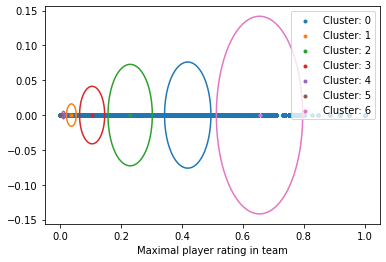

In [61]:
plt.scatter(x[:, 0], np.zeros(len(x[:, 0])), marker='.')
for i in range(k):
    t = np.linspace(0, 2*np.pi, 100)
    r = np.sqrt(sigmas[i])
    circle = plt.plot(mus[i] + r*np.cos(t) , r*np.sin(t))
    mu = plt.scatter(mus[i], 0, marker='.', color=circle[0].get_color(), label=f'Cluster: {i}')
plt.legend()
plt.xlabel("Maximal player rating in team")

In [54]:
def classify(point, pis, mus, sigmas):
    probabilites = np.array([ pis[i] * sp.stats.multivariate_normal.pdf(point, mean=mus[i], cov=sigmas[i]) for i in range(k) ])
    return np.argmax(probabilites)

In [60]:
classify(0.9, pis, mus, sigmas)

1.1491867066233894e-08


6